In [2]:
import torch

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

In [3]:
import matplotlib.pyplot as plt

In [4]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['xtick.labelsize'] = 48
plt.rcParams['ytick.labelsize'] = 48

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from botorch.models import SingleTaskGP
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from botorch.acquisition import LogExpectedImprovement
from botorch.utils.sampling import draw_sobol_samples
from gpytorch.kernels import MaternKernel, ScaleKernel
from pandora_automl.utils import fit_gp_model
from pandora_automl.acquisition.gittins import GittinsIndex
from botorch.sampling.pathwise import draw_kernel_feature_paths


def plot_posterior(ax, objective_function, model, test_x, train_x, train_y, maximize=False):
    with torch.no_grad():
        objective_y = objective_function(test_x.view(-1, 1)).detach().numpy()
        ax.plot(test_x.cpu().numpy(), objective_y, 'tab:grey', alpha=0.6, linewidth=3, label='Objective')
        
        # Compute posterior predictions
        posterior = model.posterior(test_x.unsqueeze(-1).unsqueeze(-1))
        mean = posterior.mean.squeeze().cpu().numpy()
        lower, upper = posterior.mvn.confidence_region()
        lower = lower.squeeze().cpu().numpy()
        upper = upper.squeeze().cpu().numpy()
        
        # Plot all training points as black stars
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*', alpha=0.8, markersize=30, label='Observed Points')
        
        # Determine the best observed point and mark it with a red circle
        if maximize:
            best_idx = torch.argmax(train_y)
        else:
            best_idx = torch.argmin(train_y)
        best_x = train_x[best_idx]
        best_y = train_y[best_idx]
        ax.plot(best_x.cpu().numpy(), best_y.cpu().numpy(), 'r*', markersize=30, label='Current Best Observed')
        
        # Plot posterior mean and confidence interval
        ax.plot(test_x.cpu().numpy(), mean, color='blue', linewidth=3, label='Posterior Mean')
        ax.fill_between(test_x.cpu().numpy(), lower, upper, alpha=0.2, color='blue', label='Confidence Interval')
        
        # Place the legend at the bottom in a row
        # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=40)
        return objective_y, mean, lower, upper


def plot_acquisition(ax, test_x, acquisition_function, current_best=None, acquisition_name='Acquisition', ln_lines=None):
    acq = acquisition_function(test_x.unsqueeze(-1).unsqueeze(-1)).detach().numpy()
    ax.plot(test_x.numpy(), acq, linewidth=3, label=acquisition_name)

    if ln_lines is not None:
        for ln in ln_lines:
            ax.axhline(np.log(ln), linestyle='--', color='grey', linewidth=3, label=f'ln({ln})')

    if current_best is not None:
        ax.axhline(current_best, linestyle='--', color='grey', linewidth=3, label='Current Best Observed')

    # Place the legend at the bottom in a row
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=40)

In [6]:
import numpy as np

seed = 42

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraAutoML/automl_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraAutoML/automl_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0489]), std = tensor([0.2754])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 0.7194359832252877
Iteration 0, measuring at x=0.78, y=0.33622235221936825


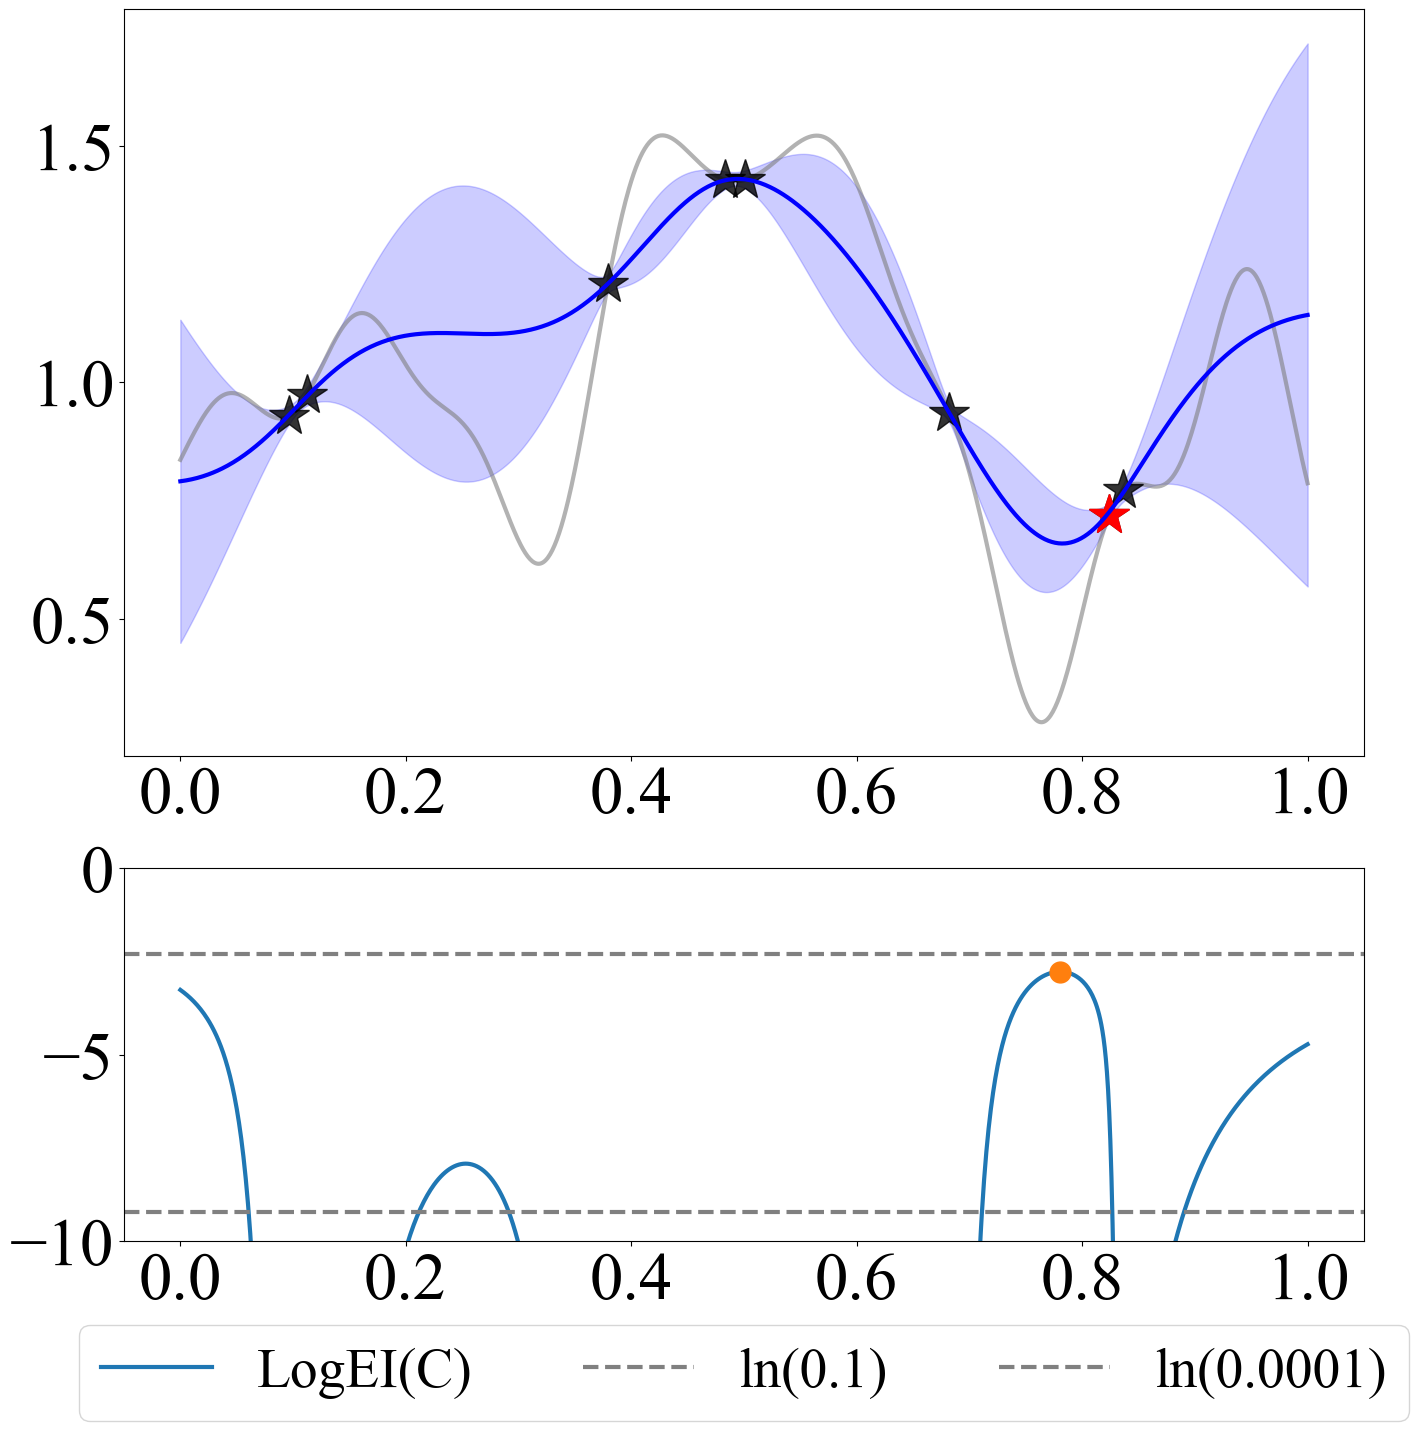

In [10]:
seed = seed
torch.manual_seed(seed)

maximize = False

# Example Usage for 1D
dim = 1

# Define your kernel
nu = 2.5
lengthscale = 0.1
outputscale = 1.0
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = torch.tensor([[lengthscale]])
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])

# Define Noise Level
noise_level = 1e-4

# Initialize Placeholder Data with Correct Dimensions
num_samples = 1  # Replace with actual number of samples
num_features = 1  # Replace with actual number of features
train_X = torch.empty(num_samples, num_features)  # Placeholder data
train_Y = torch.empty(num_samples, 1)             # Placeholder data
Yvar = torch.ones(num_samples) * noise_level

# Initialize Model
model = SingleTaskGP(train_X, train_Y, likelihood = FixedNoiseGaussianLikelihood(noise=Yvar), covar_module=scale_kernel)

from gpytorch.kernels import MaternKernel, ScaleKernel
# Set up the kernel
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = lengthscale
base_kernel.raw_lengthscale.requires_grad = False
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])
scale_kernel.raw_outputscale.requires_grad = False

matern_sample = draw_kernel_feature_paths(model, sample_shape=torch.Size([1]))
def objective_function(x):
    return matern_sample(x).squeeze(0).detach()

bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
init_x = draw_sobol_samples(bounds=bounds, n=1, q=4*(dim+1)).squeeze(0)

x = init_x
y = objective_function(x)
best_f = y.max().item() if maximize else y.min().item()

EI_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
    
model = fit_gp_model(x, y, scale_kernel)

# Optimize EI
BoTorch_EI = LogExpectedImprovement(model=model, best_f=best_f, maximize=maximize)

# Plot the posterior and the EI
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [2, 1]})
test_x = torch.linspace(0, 1, 1001)

# Plot the posterior
objective_y, mean, lower, upper = plot_posterior(ax1,objective_function,model,test_x,x,y)

# Plot EI
acq = BoTorch_EI.forward(test_x.unsqueeze(1).unsqueeze(1))
new_point, new_point_EI = test_x[torch.argmax(acq)], torch.max(acq)
plot_acquisition(ax2, test_x, BoTorch_EI.forward, ln_lines=[0.1, 0.0001], acquisition_name='LogEI(C)')
ax2.plot(new_point.numpy(), new_point_EI.detach().numpy(),'.', markersize=30)
ax2.set_ylim(-10,0)

# Reshape or transpose if necessary (depends on how you want to align them)
# arrays_combined = np.column_stack((test_x.cpu().numpy(), objective_y, mean, lower, upper, acq.detach().numpy()))

# Save to CSV
# np.savetxt('plot/exp(LogEI_acq).csv', arrays_combined, delimiter=',', fmt='%f', header='x, f(x), mean, lower, upper, acq')

print('Iteration 0, measuring at x={}, y={}'.format(new_point.item(), objective_function(new_point).item()) )
# ax2.axis("off")
# plt.tight_layout()
# plt.savefig('plot/LogEI_acq.pdf', format='pdf')
plt.show()

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraAutoML/automl_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraAutoML/automl_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0489]), std = tensor([0.2754])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 0.7194359832252877
Iteration 0, measuring at x=1.0, y=0.7864281689528502


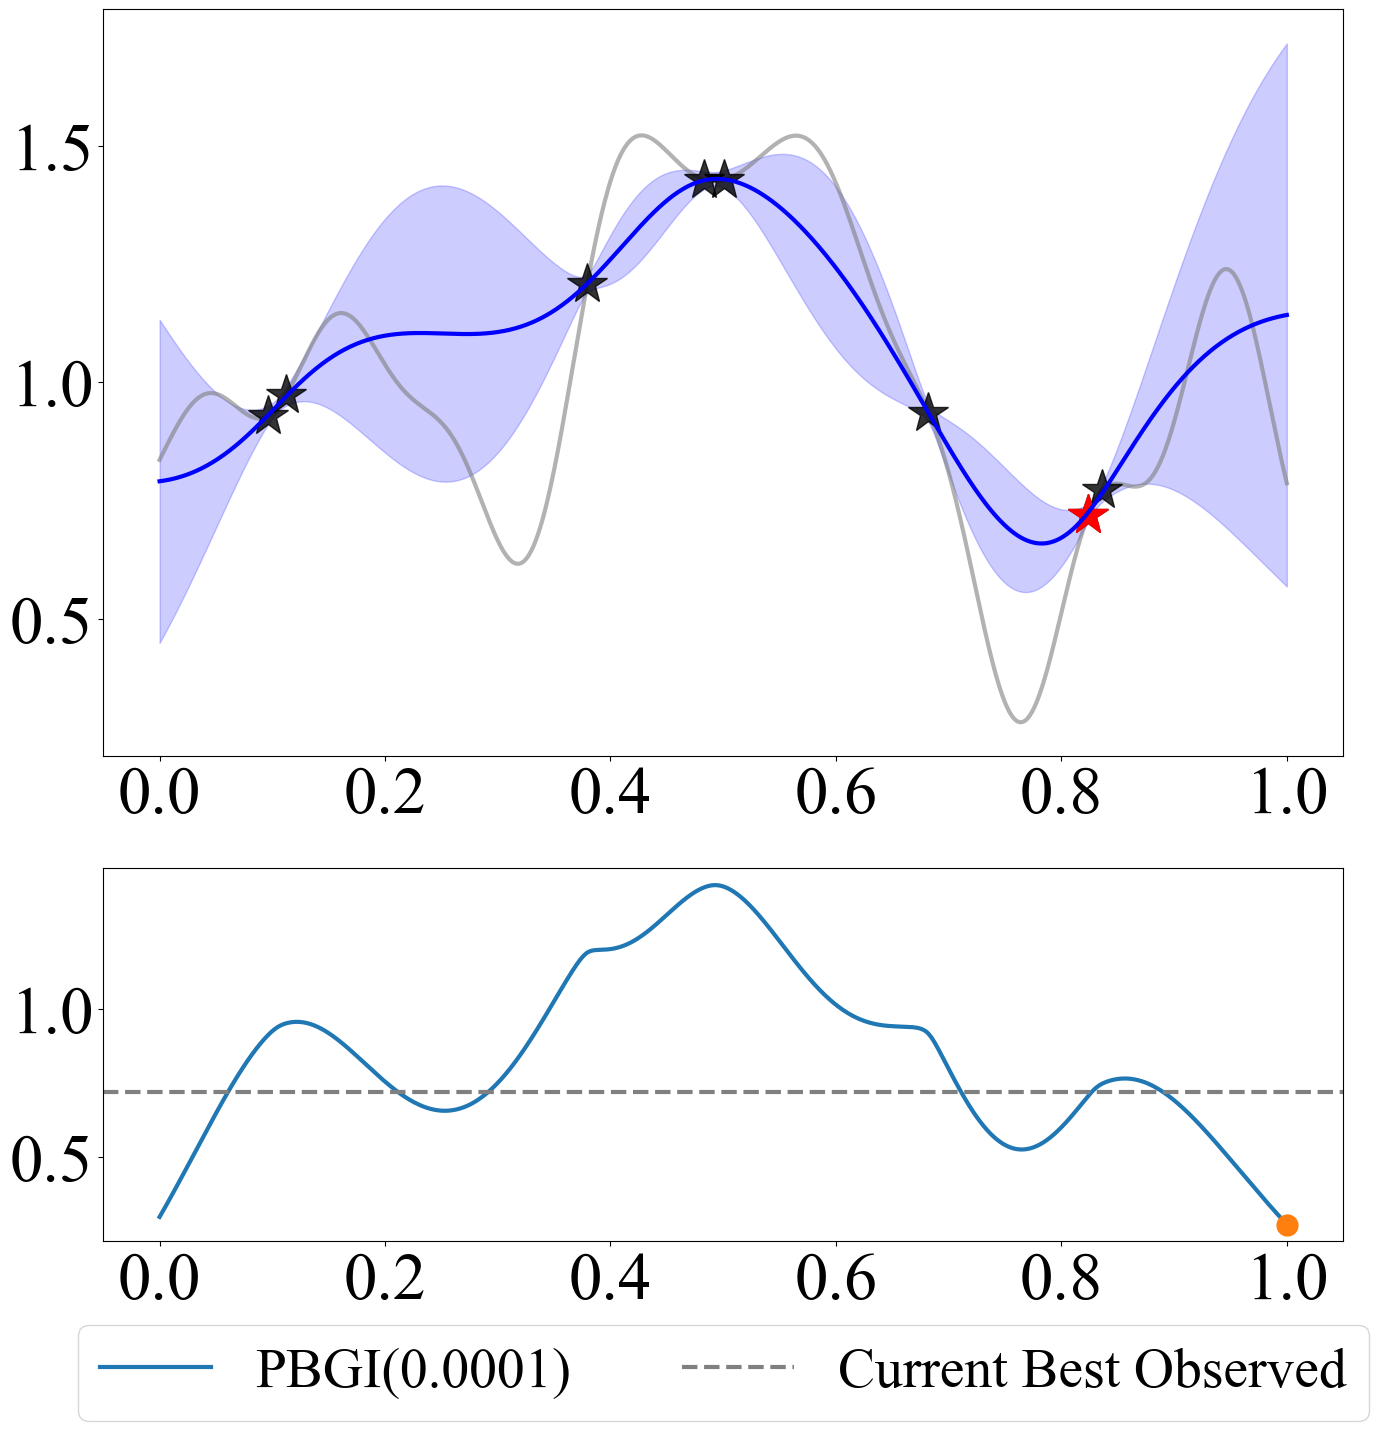

In [7]:
maximize = False
from pandora_automl.acquisition.gittins import GittinsIndex

seed = seed
torch.manual_seed(seed)

# Example Usage for 1D
dim = 1

# Define your kernel
nu = 2.5
lengthscale = 0.1
outputscale = 1.0
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = torch.tensor([[lengthscale]])
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])

# Define Noise Level
noise_level = 1e-4

# Initialize Placeholder Data with Correct Dimensions
num_samples = 1  # Replace with actual number of samples
num_features = 1  # Replace with actual number of features
train_X = torch.empty(num_samples, num_features)  # Placeholder data
train_Y = torch.empty(num_samples, 1)             # Placeholder data
Yvar = torch.ones(num_samples) * noise_level

# Initialize Model
model = SingleTaskGP(train_X, train_Y, likelihood = FixedNoiseGaussianLikelihood(noise=Yvar), covar_module=scale_kernel)

from gpytorch.kernels import MaternKernel, ScaleKernel
# Set up the kernel
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = lengthscale
base_kernel.raw_lengthscale.requires_grad = False
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])
scale_kernel.raw_outputscale.requires_grad = False

matern_sample = draw_kernel_feature_paths(model, sample_shape=torch.Size([1]))
def objective_function(x):
    return matern_sample(x).squeeze(0).detach()

bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
init_x = draw_sobol_samples(bounds=bounds, n=1, q=4*(dim+1)).squeeze(0)
lmbda = 0.0001

x = init_x
y = objective_function(x)
best_f = y.max().item() if maximize else y.min().item()

GI_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
    
model = fit_gp_model(x, y, scale_kernel)

# Optimize GI
GI = GittinsIndex(model=model, maximize=maximize, lmbda=lmbda)

# Plot the posterior and the GI
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [2, 1]})
test_x = torch.linspace(0, 1, 1001)

# Plot the posterior
plot_posterior(ax1,objective_function,model,test_x,x,y)

# Plot GI
acq = GI.forward(test_x.unsqueeze(1).unsqueeze(1))
new_point, new_point_GI = test_x[torch.argmin(acq)], torch.min(acq)
plot_acquisition(ax2, test_x, GI.forward, current_best=best_f, acquisition_name='PBGI(0.0001)')
ax2.plot(new_point.numpy(), new_point_GI.detach().numpy(),'.', markersize=30)
# ax2.axis("off")
# plt.tight_layout()

# Reshape or transpose if necessary (depends on how you want to align them)
# arrays_combined = np.column_stack((test_x.cpu().numpy(), objective_y, mean, lower, upper, acq.detach().numpy()))

# Save to CSV
# np.savetxt('plot/PBGI_acq_small.csv', arrays_combined, delimiter=',', fmt='%f', header='x, f(x), mean, lower, upper, acq')

print('Iteration 0, measuring at x={}, y={}'.format(new_point.item(), objective_function(new_point).item()))
# plt.savefig('plot/PBGI_acq_small.pdf', format='pdf')
plt.show()

/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraAutoML/automl_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)
/Users/qianxie/Desktop/Curriculum/Graduate/Research/PandoraAutoML/automl_env/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([1.0489]), std = tensor([0.2754])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


best oberved value: 0.7194359832252877
Iteration 0, measuring at x=0.782, y=0.34988090333259286


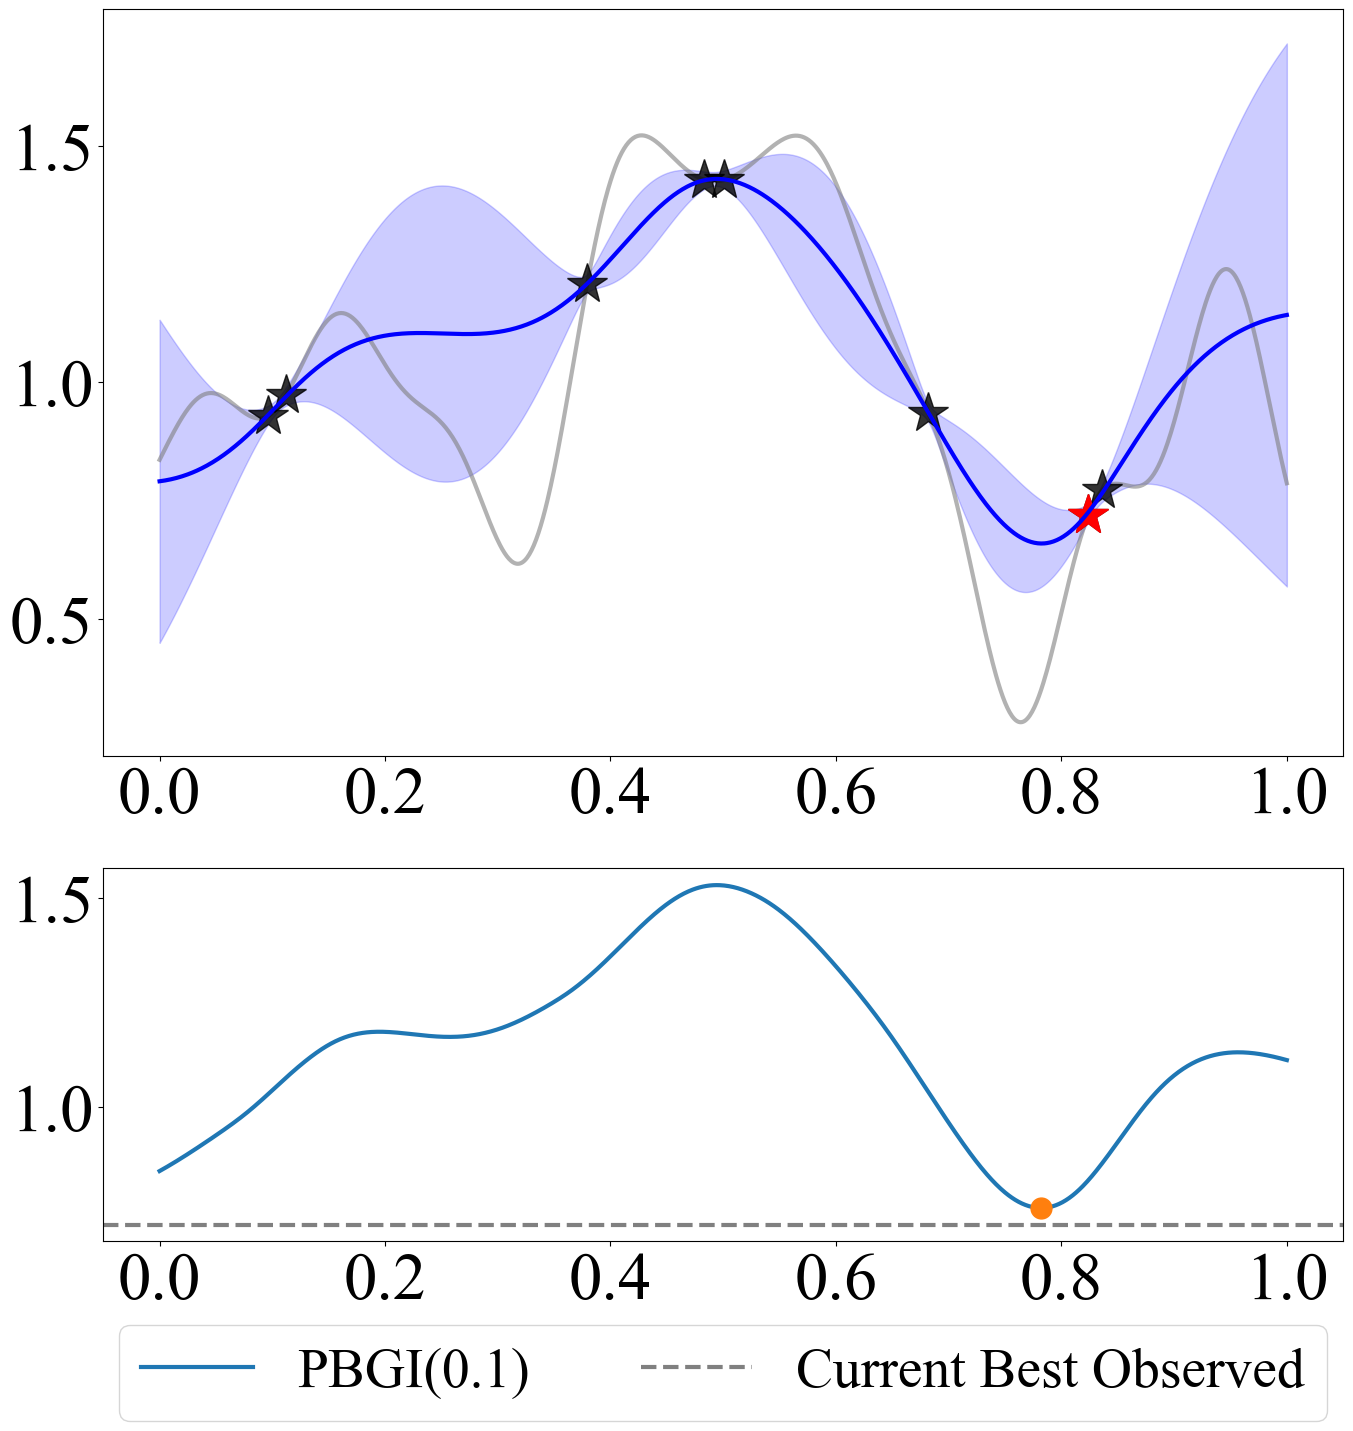

In [8]:
maximize = False
from pandora_automl.acquisition.gittins import GittinsIndex

seed = seed
torch.manual_seed(seed)

# Example Usage for 1D
dim = 1

# Define your kernel
nu = 2.5
lengthscale = 0.1
outputscale = 1.0
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = torch.tensor([[lengthscale]])
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])

# Define Noise Level
noise_level = 1e-4

# Initialize Placeholder Data with Correct Dimensions
num_samples = 1  # Replace with actual number of samples
num_features = 1  # Replace with actual number of features
train_X = torch.empty(num_samples, num_features)  # Placeholder data
train_Y = torch.empty(num_samples, 1)             # Placeholder data
Yvar = torch.ones(num_samples) * noise_level

# Initialize Model
model = SingleTaskGP(train_X, train_Y, likelihood = FixedNoiseGaussianLikelihood(noise=Yvar), covar_module=scale_kernel)

from gpytorch.kernels import MaternKernel, ScaleKernel
# Set up the kernel
base_kernel = MaternKernel(nu=nu).double()
base_kernel.lengthscale = lengthscale
base_kernel.raw_lengthscale.requires_grad = False
scale_kernel = ScaleKernel(base_kernel).double()
scale_kernel.outputscale = torch.tensor([[outputscale]])
scale_kernel.raw_outputscale.requires_grad = False

matern_sample = draw_kernel_feature_paths(model, sample_shape=torch.Size([1]))
def objective_function(x):
    return matern_sample(x).squeeze(0).detach()

bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])
init_x = draw_sobol_samples(bounds=bounds, n=1, q=4*(dim+1)).squeeze(0)
lmbda = 0.1

x = init_x
y = objective_function(x)
best_f = y.max().item() if maximize else y.min().item()

GI_best = [best_f] # This will store the best value
print("best oberved value:", best_f)
    
model = fit_gp_model(x, y, scale_kernel)

# Optimize GI
GI = GittinsIndex(model=model, maximize=maximize, lmbda=lmbda)

# Plot the posterior and the GI
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [2, 1]})
test_x = torch.linspace(0, 1, 1001)

# Plot the posterior
plot_posterior(ax1,objective_function,model,test_x,x,y)

# Plot GI
acq = GI.forward(test_x.unsqueeze(1).unsqueeze(1))
new_point, new_point_GI = test_x[torch.argmin(acq)], torch.min(acq)
plot_acquisition(ax2, test_x, GI.forward, current_best=best_f, acquisition_name='PBGI(0.1)')
ax2.plot(new_point.numpy(), new_point_GI.detach().numpy(),'.', markersize=30)
# ax2.axis("off")
# plt.tight_layout()

# Reshape or transpose if necessary (depends on how you want to align them)
# arrays_combined = np.column_stack((test_x.cpu().numpy(), objective_y, mean, lower, upper, acq.detach().numpy()))

# Save to CSV
# np.savetxt('plot/PBGI_acq_large.csv', arrays_combined, delimiter=',', fmt='%f', header='x, f(x), mean, lower, upper, acq')

print('Iteration 0, measuring at x={}, y={}'.format(new_point.item(), objective_function(new_point).item()))
# plt.savefig('plot/PBGI_acq_large.pdf', format='pdf')
plt.show()